In [1]:
import os
import sys
import re
import time
import yaml
import shutil
import argparse
import tarfile
import tempfile
import random
import subprocess
import copy

import numpy as np
import pandas as pd

import torch

import boda
from boda.common import utils
from boda.common.utils import set_best, save_model, unpack_artifact, model_fn

import hypertune

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def save_proposals(proposals, args):
    save_dict = {
        'proposals': proposals,
        'args'     : args,
        'timestamp'    : time.strftime("%Y%m%d_%H%M%S"),
        'random_tag'   : random.randint(100000,999999)
    }
    filename = f'proposals__{save_dict["timestamp"]}__{save_dict["random_tag"]}.pt'
    torch.save(save_dict, filename)
        
    if 'gs://' in args['Main args'].proposal_path:
        clound_target = os.path.join(args['Main args'].proposal_path,filename)
        subprocess.check_call(
            ['gsutil', 'cp', filename, clound_target]
        )
    else:
        os.makedirs(args['Main args'].proposal_path, exist_ok=True)
        shutil.copy(filename, args['Main args'].proposal_path)
    
    final_loc = os.path.join(args['Main args'].proposal_path,filename)
    print(f'Proposals deposited at:\n\t{final_loc}', file=sys.stderr)
    
def main(args):
    
    args_copy = copy.deepcopy(args)
    
    params_module     = getattr(boda.generator.parameters, args['Main args'].params_module)
    energy_module    = getattr(boda.generator.energy    , args['Main args'].energy_module)
    generator_module = getattr(boda.generator           , args['Main args'].generator_module)
    
    params_args     = vars(params_module.process_args(args))
    energy_args    = vars(energy_module.process_args(args))
    generator_args = generator_module.process_args(args)
    generator_constructor_args, generator_runtime_args = [ vars(arg_subset) for arg_subset in generator_args ]
    
    params    = params_module(**params_args)
    energy    = energy_module(**energy_args)
    
    if args['Main args'].penalty_module is not None:
        penalty_module = getattr(boda.generator.energy, args['Main args'].penalty_module)
        energy.__class__ = type(
            'energy_module',
            (energy_module, penalty_module),
            vars(penalty_module.process_args(args))
        )
    else:
        penalty_module = None
    current_penalty = None

    generator_constructor_args['params']    = params
    generator_constructor_args['energy_fn'] = energy
    generator_runtime_args['energy_threshold'] = args['Main args'].energy_threshold
    generator_runtime_args['max_attempts'] = args['Main args'].max_attempts
    generator = generator_module(**generator_constructor_args)
    
    params.cuda()
    energy.cuda()
    
    proposal_sets = []
    for get_n in args['Main args'].n_proposals:
        generator_runtime_args['n_proposals'] = get_n
        proposal = generator.generate(**generator_runtime_args)
        proposal['penalty'] = current_penalty
        proposal_sets.append(proposal)
        
        sns.histplot(proposal['energies'].numpy())
        plt.show()
        
        if args['Main args'].penalty_module is not None:
            current_penalty = energy.update_penalty(proposal)
            
        if args['Main args'].reset_params:
            generator.params = params_module(**params_args)
            
    save_proposals(proposal_sets, args_copy)
    return params, energy, generator, proposal_sets


In [37]:
cmd_str = '--params_module StraightThroughParameters ' +\
            '--batch_size 128 --n_channels 4 --length 200 --n_samples 10 ' +\
          '--energy_module OverMaxEnergy ' +\
            '--model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz ' +\
            '--bias_cell 2 --bending_factor 1.0 --a_min -4.0 --a_max 6.0 ' +\
          '--generator_module FastSeqProp ' +\
            '--energy_threshold -2.0 --max_attempts 10 --n_steps 300 ' +\
          '--penalty_module StremePenalty ' +\
            '--score_pct 0.25 ' +\
          '--proposal_path ./test_seqs/ --n_proposals 500 250 250 250 250 '

'python /home/ubuntu/boda2/src/generate.py ' + cmd_str

'python /home/ubuntu/boda2/src/generate.py --params_module StraightThroughParameters --batch_size 128 --n_channels 4 --length 200 --n_samples 10 --energy_module OverMaxEnergy --model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz --bias_cell 2 --bending_factor 1.0 --a_min -4.0 --a_max 6.0 --generator_module FastSeqProp --energy_threshold -2.0 --max_attempts 10 --n_steps 300 --penalty_module StremePenalty --score_pct 0.25 --proposal_path ./test_seqs/ --n_proposals 500 250 250 250 250 '

In [38]:
parser = argparse.ArgumentParser(description="BODA generator", add_help=False)
group = parser.add_argument_group('Main args')

group.add_argument('--params_module', type=str, required=True, help='')
group.add_argument('--energy_module', type=str, required=True, help='')    
group.add_argument('--generator_module', type=str, required=True, help='')
group.add_argument('--penalty_module', type=str, help='')
group.add_argument('--monitor', type=str, help='')
group.add_argument('--n_proposals', nargs='+', type=int, help='')
group.add_argument('--energy_threshold', type=float, default=float("Inf"))
group.add_argument('--max_attempts', type=int, default=10000)
group.add_argument('--reset_params', type=utils.str2bool, default=True)
group.add_argument('--proposal_path', type=str)

group.add_argument('--tolerate_unknown_args', type=utils.str2bool, default=False, help='Skips unknown command line args without exceptions. Useful for HPO, but high risk of silent errors.')


known_args, leftover_args = parser.parse_known_args(
    cmd_str.rstrip().split()
)

Params    = getattr(boda.generator, known_args.params_module)
Energy    = getattr(boda.generator.energy, known_args.energy_module)
Generator = getattr(boda.generator, known_args.generator_module)

parser = Params.add_params_specific_args(parser)
parser = Energy.add_energy_specific_args(parser)
parser = Generator.add_generator_specific_args(parser)

if known_args.penalty_module is not None:
    Penalty = getattr(boda.generator.energy, known_args.penalty_module)
    parser = Penalty.add_penalty_specific_args(parser)
    
parser.add_argument('--help', '-h', action='help')

if known_args.tolerate_unknown_args:
    args, leftover_args = parser.parse_known_args( 
        cmd_str.rstrip().split()
    )
    print("Skipping unexpected args. Check leftovers for typos:", file=sys.stderr)
    print(leftover_args, file=sys.stderr)
else:
    args = parser.parse_args(
        cmd_str.rstrip().split()
    )

args = boda.common.utils.organize_args(parser, args)

Namespace(a_max=6.0, a_min=-4.0, batch_dim=0, batch_size=128, bending_factor=1.0, bias_alpha=1.0, bias_cell=2, cat_axis=-1, energy_module='OverMaxEnergy', energy_threshold=-2.0, generator_module='FastSeqProp', init_seqs=None, learning_rate=0.5, left_flank='GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCATTACATCTGTGTGTTGGTTTTTTGTGTGAATCGATAGTACTAACATACGCTCTCCATCAAAACAAAACGAAACAAAACAAACTAGCAAAATAGGCTGTCCCCAGTGCAAGTGCAGGTGCCAGAACATTTCTCTGGCCTAACTGGCCGCTTGACG', length=200, lr_scheduler=True, max_attempts=10, model_artifact='gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz', monitor=None, n_channels=4, n_proposals=[500, 250, 250, 250, 250], n_samples=10, n_steps=300, params_module='StraightThroughParameters', penalty_module='StremePenalty', proposal_path='./test_seqs/', reset_params=True, right_flank='CACTGCGGCTCCTGCGATCTAACTGGCCGGTACCTGAGCTCGCTAGCCTCGAGGATATCAAGATCTGGCCTCGGCGGCCAAGCTTAGACACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACCATGGTGAGCAAGGGC

Steps:   0%|          | 1/300 [00:00<00:41,  7.21it/s]

Loaded model from 20211110_194934 in eval mode


Steps: 100%|██████████| 300/300 [00:38<00:00,  7.81it/s, Loss=-4.63, LR=1e-6]   


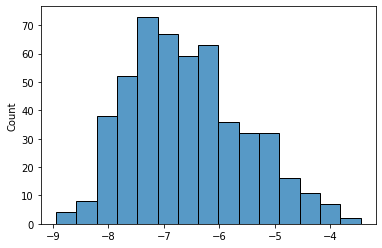

Steps: 100%|██████████| 300/300 [00:47<00:00,  6.26it/s, Loss=-2.22, LR=1e-6]   


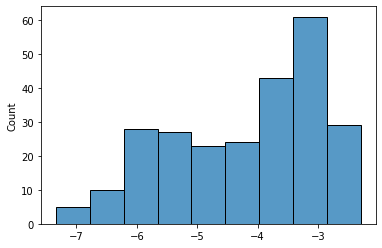

Steps: 100%|██████████| 300/300 [00:47<00:00,  6.26it/s, Loss=-1.41, LR=1e-6]   


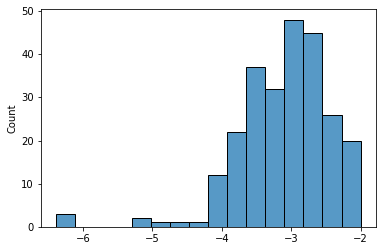

Steps: 100%|██████████| 300/300 [00:48<00:00,  6.24it/s, Loss=-.185, LR=1e-6]    


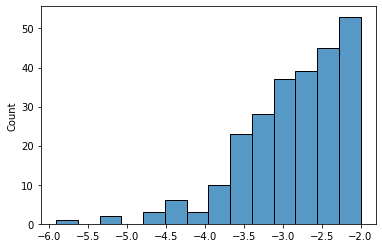

Steps: 100%|██████████| 300/300 [00:48<00:00,  6.24it/s, Loss=2.62, LR=1e-6]   


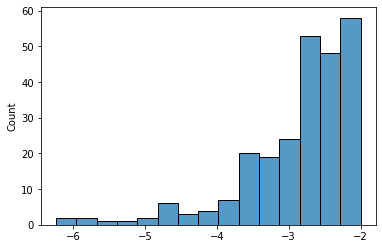

Proposals deposited at:
	./test_seqs/proposals__20211202_043413__529287.pt


In [39]:
params, energy, generator, proposal_sets = main(args)

In [40]:
for i in range(len(proposal_sets)):
    print(f'round {i}: {proposal_sets[i]["proposals"].shape[0]}')
    print(f'\tacceptance rate: {proposal_sets[i]["acceptance_rate"]}')

round 0: 500
	acceptance rate: 1.0
round 1: 250
	acceptance rate: 0.98828125
round 2: 250
	acceptance rate: 0.9479166865348816
round 3: 250
	acceptance rate: 0.7942708134651184
round 4: 250
	acceptance rate: 0.7057291865348816


In [16]:
from boda.common import constants
from boda.common.utils import align_to_alphabet
from boda.generator.plot_tools import ppm_to_IC, matrix_to_dms
from boda.common.pymeme import parse_streme_output

def ppm_to_pcm(in_tensor, bkg=[0.25,0.25,0.25,0.25], contour_base=1.5):
    argument = in_tensor.div(torch.tensor(bkg).unsqueeze(1))
    motif = torch.log2(argument) #* contour_base ** torch.maximum(argument-1.9, torch.zeros_like(argument))
    return motif

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_order=alphabet,  out_order=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output, plot_type=ppm_to_IC):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    for motif_idx in range(len(motif_dict)):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(plot_type(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(plot_type(motif_ppm_rc), y_max=2)
        plt.show()

------------------------ Round 1 ------------------------
{'alength': 4, 'w': 10, 'nsites': 405, 'E': 2.2e-11}


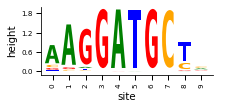

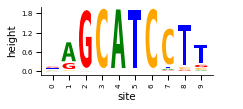

{'alength': 4, 'w': 15, 'nsites': 202, 'E': 1.2e-08}


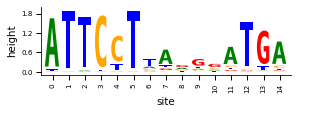

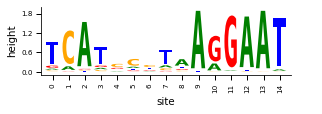

{'alength': 4, 'w': 13, 'nsites': 283, 'E': 5.5e-07}


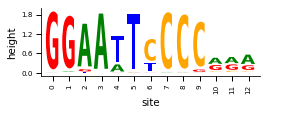

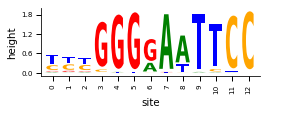

{'alength': 4, 'w': 9, 'nsites': 213, 'E': 0.00016}


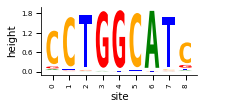

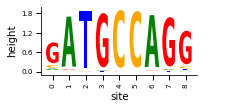

{'alength': 4, 'w': 9, 'nsites': 160, 'E': 0.0075}


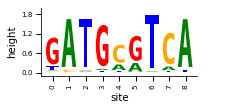

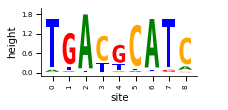

{'alength': 4, 'w': 9, 'nsites': 34, 'E': 1.4}


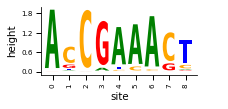

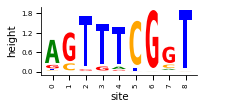

{'alength': 4, 'w': 11, 'nsites': 66, 'E': 2}


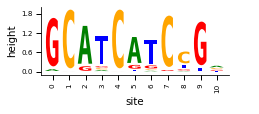

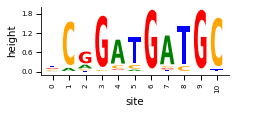

{'alength': 4, 'w': 8, 'nsites': 55, 'E': 6.6}


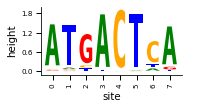

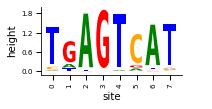

------------------------ Round 2 ------------------------
{'alength': 4, 'w': 9, 'nsites': 163, 'E': 4.2e-05}


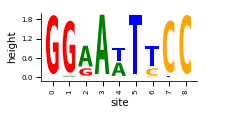

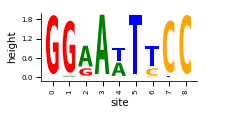

{'alength': 4, 'w': 8, 'nsites': 85, 'E': 0.033}


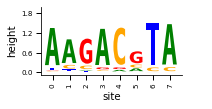

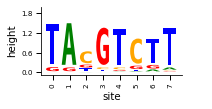

{'alength': 4, 'w': 10, 'nsites': 85, 'E': 0.093}


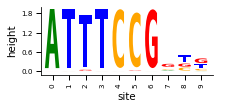

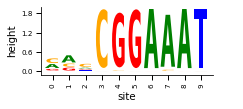

{'alength': 4, 'w': 11, 'nsites': 73, 'E': 0.3}


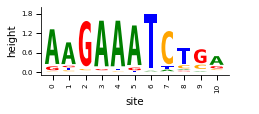

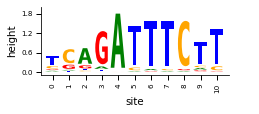

{'alength': 4, 'w': 9, 'nsites': 91, 'E': 0.38}


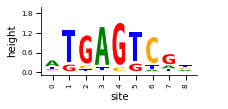

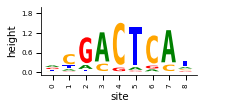

{'alength': 4, 'w': 10, 'nsites': 78, 'E': 0.94}


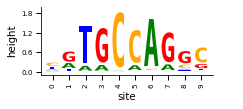

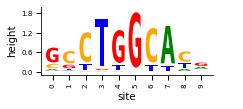

{'alength': 4, 'w': 10, 'nsites': 67, 'E': 1.7}


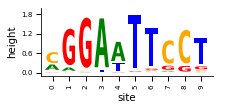

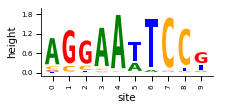

{'alength': 4, 'w': 12, 'nsites': 32, 'E': 4}


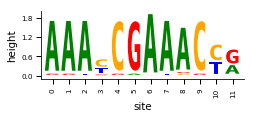

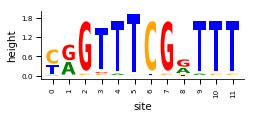

------------------------ Round 3 ------------------------
{'alength': 4, 'w': 13, 'nsites': 115, 'E': 0.00026}


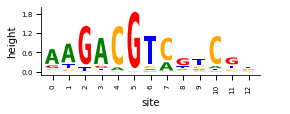

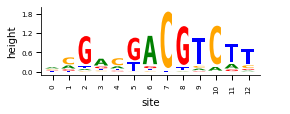

{'alength': 4, 'w': 10, 'nsites': 136, 'E': 0.19}


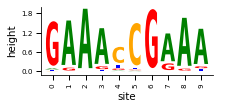

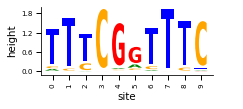

{'alength': 4, 'w': 11, 'nsites': 85, 'E': 0.29}


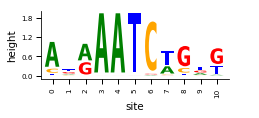

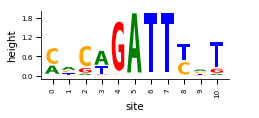

{'alength': 4, 'w': 9, 'nsites': 37, 'E': 0.7}


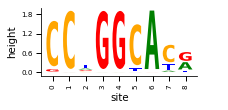

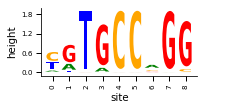

{'alength': 4, 'w': 8, 'nsites': 160, 'E': 3}


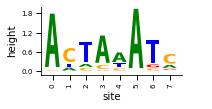

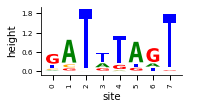

{'alength': 4, 'w': 8, 'nsites': 71, 'E': 3}


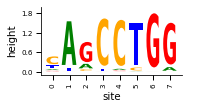

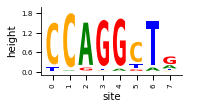

------------------------ Round 4 ------------------------
{'alength': 4, 'w': 14, 'nsites': 126, 'E': 0.0022}


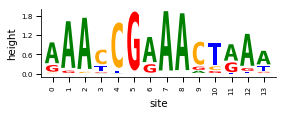

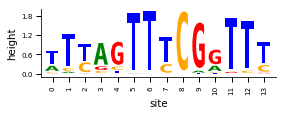

{'alength': 4, 'w': 13, 'nsites': 94, 'E': 0.078}


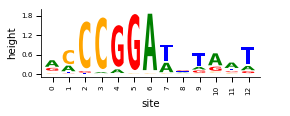

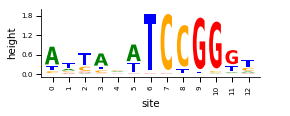

{'alength': 4, 'w': 8, 'nsites': 34, 'E': 0.18}


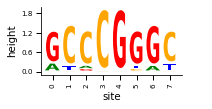

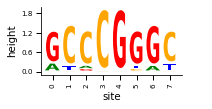

{'alength': 4, 'w': 9, 'nsites': 91, 'E': 0.34}


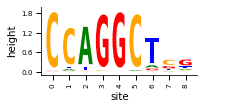

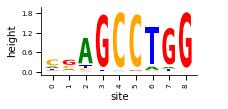

{'alength': 4, 'w': 12, 'nsites': 43, 'E': 0.82}


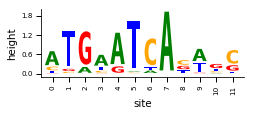

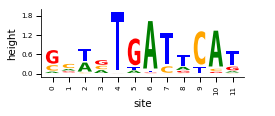

{'alength': 4, 'w': 8, 'nsites': 53, 'E': 2.3}


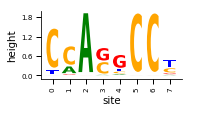

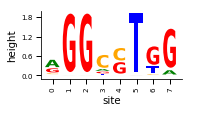

{'alength': 4, 'w': 12, 'nsites': 85, 'E': 2.5}


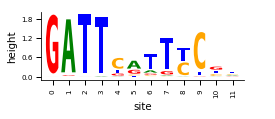

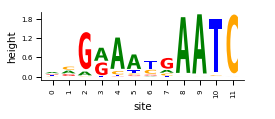

In [41]:
pen_round = 1
for pen_round in range(1,5):
    print(f'------------------------ Round {pen_round} ------------------------')
    show_streme_motifs(
        parse_streme_output(proposal_sets[pen_round]['penalty']['streme_output']['output']),
        plot_type=ppm_to_IC
    )